## Start by understand LSTMs
[LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Same in PDF format](https://filedn.com/lK1VhM9GbBxVlERr9KFjD4B/deep_learning_resources/timeseries/Understanding_LSTMs.pdf)

[Connection to OOP](https://www.kdnuggets.com/2019/08/simple-mix-object-oriented-programming-sharpen-deep-learning-prototype.html)

## Count Regression Problem

### Problem Setup
The data includes weekly occurrence counts of 11 keywords related to a disease
in an online discussion forum. The goal is to predict the official weekly disease
counts. The name of the disease and keywords are not relevant, thus are not
given.
The data is divided into training and test sets.
Training set has 282 rows (weeks), 13 columns. First column is the date of the
start of that particular week, next 11 columns are the keyword counts during
that week and the last column is the target which is the official weekly count of
number of people having that disease in that week.
The test set (52 rows) structure is the same, except that it does not have the
last column, i.e., target values.

#### TASK
The task is to create a machine learning model, trained on the training set, to
predict the weekly disease counts on the test set.

### Poisson Regression ?
The question is whether the logarithm of the weekly disease counts can be modeled as a linear combination of the weekly keyword counts.
It is unnatural to assume that the logarithm one count variable could be modeled as a linear combination of other counts, thus Poisson Regression is not the approach to take here.

### Black-Box Approach with Uncertainty Estimate ?
Nevertheless, the black-box model should always be possible to be implemented due to the universal approximation theorem.

We are going to use LSTM Neural network with MSE error. We could also consider turning this into a classification problem, but we would probably need at least 17 classes, thus not recommended.

To simulate the Bayesian approach :
The fact of randomly turning neurons on and off is roughly equivalent to performing a sampling of a Bernoulli distribution, and therefore “simulates” the mechanics of a Bayesian Neural Network (where weights are distributions, and not single values). Applying dropout is a bit like if we were “sampling” from the network. And if we repeat this process several times during inference, we will get different predictions with which we can estimate a distribution and eventually, uncertainty !

This paper is inspired by the Monte Carlo dropout (MC dropout) framework proposed in [13] and [22], which
requires no change of the existing model architecture and provides uncertainty estimation almost for free. Specifically, stochastic dropouts are applied after each hidden layer, and the model output can be approximately viewed as a random sample generated from the posterior predictive distribution
[21]. As a result, the model uncertainty can be estimated by the sample variance of the model predictions in a few
repetitions.

## Getting Data, Preprocessing and Generating Features

In [ ]:
#!pip install --upgrade tensorflow --user
!pip install --upgrade numpy  --user

In [263]:
os.chdir("/media/sf_dl_projects_combined/ml_for_python_2019_/4_revision_python_programming/pytorch_problem")

train_path = os.path.abspath(
    os.path.join(
        "data",
        'training_set.csv'
    )
)

test_path = os.path.abspath(
    os.path.join(  
        "data",
        'test_set.csv'
    )
)

raw_train = pd.read_csv(train_path,delimiter=";",header=None)
raw_test = pd.read_csv(test_path,delimiter=";",header=None)

data_dict_features = {"trainX":raw_train.loc[:,:raw_train.shape[1]-2],"testX":raw_test}


### Train and Test Set have to have the same amount of Features

In [268]:
# So we have 12 feaures of counts (one corresponds to datetime)
#data_dict_features.get("testX").head()
print((raw_train.loc[:,:raw_train.shape[1]-2]).shape) 
print(raw_test.shape)

(282, 12)
(52, 12)


In [112]:
# havent used yet
def generate_data_units(data,nolabel):
    if nolabel == False:
        print(data.shape[1])
        X = data.loc[:,1:data.shape[1]-2]
        print(f"Amount of train features {X.shape[1]}")
        y = data.loc[:,data.shape[1]-1]
    else :
        y = []
        X = data.loc[:,1:data.shape[1]-1]
        print(f"Amount of test features {X.shape[1]}")
    return X,y,no_features

#trainX,trainy,no_features = generate_data_units(data=train,nolabel=False)
#testX,_,__ = generate_data_units(data=test,nolabel=True)
#no_features

### Setting Datetime as Index 

In [269]:
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd

kwargs = {"n_in":10,"n_out":5,"dropnan":False,"col": 0}

################## TRANSFORM TRAIN AND TEST TOGETHER USING THIS #########3
def apply_fun(dict_:dict,fun,**kwargs):
    transformed_dict = dict((k, fun(v,**kwargs)) for k, v in dict_.items())
    return transformed_dict

def properly_set_time_idx(data:pd.DataFrame,**kwargs):
    s = data.set_index(pd.DatetimeIndex(data.loc[:,kwargs.get("col")]),inplace=False)
    if 0 in s.columns:
        s.drop([0],axis=1,inplace=True)
    return s

generated_features = apply_fun(data_dict_features,fun=properly_set_time_idx,**kwargs)


### Generate Time Series Features by Rolling (Shifting)

In [270]:
def generate_ts_features(data : pd.DataFrame, **kwargs ):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_in= kwargs.get("n_in")
    n_out= kwargs.get("n_out")
    dropnan= kwargs.get("dropnan")
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data.values
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    
    for i in range(n_in, 0, -1):
        cols.append(pd.DataFrame(np.roll(df,i,axis=0)))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(pd.DataFrame(np.roll(df,-i,axis=0)))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

generated_features_numpy_roll = apply_fun(generated_features,fun=generate_ts_features,**kwargs)
generated_features_numpy_roll["trainy"] = raw_train.loc[:,raw_train.shape[1]-1]


In [271]:
apply_fun(generated_features_numpy_roll,fun=lambda x : x.shape)

{'trainX': (282, 165), 'testX': (52, 165), 'trainy': (282,)}

As you see from below, time series delay features have been generated. Now the neural network can used both the original time series as well as all possibly delayed versions of it.

In [251]:
apply_fun(generated_features_numpy_roll,fun=pd.DataFrame.head)

{'trainX':    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
 0         4.0         1.0         2.0         2.0        20.0         0.0   
 1        14.0         1.0         2.0         2.0        25.0         1.0   
 2         5.0         1.0         6.0         4.0        24.0         1.0   
 3         6.0         0.0         0.0         0.0        17.0         0.0   
 4         5.0         3.0         2.0         1.0        16.0         0.0   
 
    var7(t-10)  var8(t-10)  var9(t-10)  var10(t-10)  ...  var3(t+4)  var4(t+4)  \
 0         1.0         2.0        17.0          1.0  ...        3.0        5.0   
 1         0.0         9.0        23.0          4.0  ...        8.0        7.0   
 2         0.0         5.0        13.0         12.0  ...        7.0        9.0   
 3         0.0         5.0        10.0          5.0  ...       12.0        3.0   
 4         0.0         7.0        18.0          5.0  ...        3.0        6.0   
 
    var5(t+4)  var6(t+4)  

### Splitting the Data for Evaluation ; Reshaping for Input to LSTM

In [272]:
from sklearn.model_selection import train_test_split
X,y  = generated_features_numpy_roll.get("trainX").values, generated_features_numpy_roll.get("trainy").values
X_test = generated_features_numpy_roll.get("testX").values                                                
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.33, random_state=42)

### Reshaping to conform to LSTM 
# reshape input to be 3D [samples, timesteps, features]
n_in = kwargs.get("n_in")
n_out = kwargs.get("n_out")

X_train = X_train.reshape((X_train.shape[0],n_in + n_out , -1))
X_validate = X_validate.reshape((X_validate.shape[0], n_in + n_out, -1)) # X_validate.shape[1]
X_test = X_test.reshape((X_test.shape[0], n_in + n_out, -1)) # X_validate.shape[1]


print(X_train.shape, y_train.shape, X_validate.shape, y_validate.shape,X_test.shape)



(188, 15, 11) (188,) (94, 15, 11) (94,) (52, 15, 11)


##  Simple LSTM Approach with Keras

In [298]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD


kwargs_training = {"momentum":0.8,"decay":0.1,"lr":0.01,"lstm_units":80,\
                   "optimizer":"sgd","dropout_probability":0.2,"loss_":"mae"}
def model_string(**kwargs):
    return ', '.join('%s=%r' % x for x in kwargs.items())

def create_model(**kwargs):
    loss_ = kwargs.get("loss_")
    optimizer_ = kwargs.get("optimizer")
    if optimizer_ == "sgd":
          decay,momentum,lr = kwargs.get("decay"), kwargs.get("momentum"),kwargs.get("lr")
    dropout_probability = kwargs.get("dropout_probability")
    lstm_units = kwargs.get("lstm_units")
    model = tf.keras.Sequential()
    sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False)
  
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]))) # LSTM input is timesteps x features
    # https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
    model.add(Dropout(dropout_probability))
    model.add(Dense(1)) # predicting one dependent variable
    model.compile(loss=loss_,optimizer = optimizer_ ) #  or optimizer='adam'
   
    modelstring = model_string(**kwargs)
    return model,modelstring


### Model 1

Train on 188 samples, validate on 94 samples
Epoch 1/200
188/188 - 3s - loss: 27.8968 - val_loss: 41.9293
Epoch 2/200
188/188 - 0s - loss: 26.2010 - val_loss: 40.9348
Epoch 3/200
188/188 - 0s - loss: 25.5944 - val_loss: 40.4223
Epoch 4/200
188/188 - 1s - loss: 25.3523 - val_loss: 40.1713
Epoch 5/200
188/188 - 0s - loss: 25.2422 - val_loss: 40.0027
Epoch 6/200
188/188 - 0s - loss: 25.1746 - val_loss: 39.9293
Epoch 7/200
188/188 - 0s - loss: 25.1588 - val_loss: 39.8007
Epoch 8/200
188/188 - 1s - loss: 25.0664 - val_loss: 39.8054
Epoch 9/200
188/188 - 1s - loss: 24.9841 - val_loss: 39.7287
Epoch 10/200
188/188 - 0s - loss: 24.9334 - val_loss: 39.6160
Epoch 11/200
188/188 - 1s - loss: 24.8593 - val_loss: 39.7895
Epoch 12/200
188/188 - 0s - loss: 24.9153 - val_loss: 40.1319
Epoch 13/200
188/188 - 1s - loss: 24.8637 - val_loss: 39.8150
Epoch 14/200
188/188 - 0s - loss: 24.8786 - val_loss: 39.5098
Epoch 15/200
188/188 - 0s - loss: 24.8065 - val_loss: 39.4745
Epoch 16/200
188/188 - 1s - loss: 

188/188 - 1s - loss: 21.5271 - val_loss: 36.5145
Epoch 133/200
188/188 - 1s - loss: 21.4557 - val_loss: 36.7753
Epoch 134/200
188/188 - 0s - loss: 21.7467 - val_loss: 37.0760
Epoch 135/200
188/188 - 0s - loss: 21.7166 - val_loss: 36.8293
Epoch 136/200
188/188 - 0s - loss: 21.6009 - val_loss: 36.5745
Epoch 137/200
188/188 - 1s - loss: 21.3160 - val_loss: 36.6040
Epoch 138/200
188/188 - 0s - loss: 21.5528 - val_loss: 36.5726
Epoch 139/200
188/188 - 1s - loss: 21.3435 - val_loss: 36.9936
Epoch 140/200
188/188 - 0s - loss: 21.2798 - val_loss: 37.8046
Epoch 141/200
188/188 - 0s - loss: 21.9226 - val_loss: 36.4779
Epoch 142/200
188/188 - 0s - loss: 21.5837 - val_loss: 36.7371
Epoch 143/200
188/188 - 1s - loss: 21.3331 - val_loss: 36.5396
Epoch 144/200
188/188 - 0s - loss: 21.4419 - val_loss: 36.5939
Epoch 145/200
188/188 - 1s - loss: 21.1287 - val_loss: 36.7319
Epoch 146/200
188/188 - 0s - loss: 21.4508 - val_loss: 36.7234
Epoch 147/200
188/188 - 0s - loss: 21.3530 - val_loss: 36.7118
Epoch 

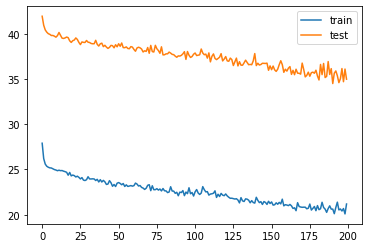

In [306]:

# FITTING #
epochs1 = 200
model,modelstring = create_model(**kwargs_training)
history1 = model.fit(X_train, y_train, epochs=epochs1, batch_size=30, \
                    validation_data=(X_validate, y_validate), verbose=2, shuffle=False)

model.save(f"models/{modelstring}_model.h5")  # creates a HDF5 file 
model.save_weights(f"models/{modelstring}_model_weights.h5")  # creates a HDF5 file 'my_model.h5'

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()



In [ ]:
print(f"The best validation with this LSTM model with {epochs_} epochs was {history1.history['val_loss'][-1]}")

### LSTM Model 2

In [303]:
kwargs_training2 = {"momentum":0.8,"decay":0.1,"lr":0.01,"lstm_units":80,\
                   "optimizer":"adam","dropout_probability":0.2,"loss_":"mae"}
model2,modelstring2 = create_model(**kwargs_training)
epochs_ = 200
#history = model.fit(X_train, y_train, epochs=epochs_, batch_size=30, \
#                    validation_data=(X_validate, y_validate), verbose=2, shuffle=False)

model2.save(f"{modelstring2}_model.h5")  # creates a HDF5 file 
model2.save_weights(f"{modelstring2}_model_weights.h5")  # creates a HDF5 file 'my_model.h5'
print(f"The best validation with this LSTM model with {epochs_} epochs was {history.history['val_loss'][-1]}")

The best validation with this LSTM model with 200 epochs was 37.4167932145139


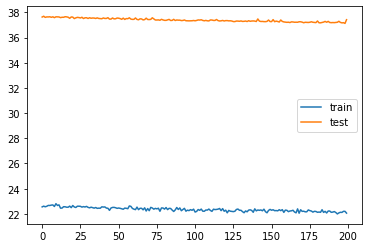

In [304]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

### From the Graph we can clearly see the overfitting problem!

## Summary
### Since Model 1 did better, we will use that to get the Test Predictions

In [314]:
import tensorflow as tf
generated_features_numpy_roll.keys()
#generated_features_numpy_roll["test"] = generated_features_numpy_roll["test"].values.reshape((generated_features_numpy_roll["test"].shape[0], n_in + n_out, -1)) # X_validate.shape[1]

# Getting final predictions 
testpredictions = np.round(model.predict(X_test, verbose=0),0)


In [322]:
print(X_train.shape, y_train.shape, X_validate.shape, y_validate.shape,X_test.shape)
# X_train has shape [samples x timesteps x features]

(188, 15, 11) (188,) (94, 15, 11) (94,) (52, 15, 11)


### To improve the model:
    - Generate more features
    - Generate synthetic data
    - Try more complex model

## Simple Encoder-Decoder LSTM Approach